In [64]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import SGDRegressor

In [79]:
# 1. DATA LOADING AND PREPARATION

california_houses=pd.read_csv("datasets/California_Houses.csv")

# Separate features (X) and target (T)
X = california_houses.drop(columns=['Median_House_Value'])
T = california_houses['Median_House_Value']


# Shuffle the data to ensure randomness
shuffled_data = pd.concat([X, T], axis=1).sample(frac=1, random_state=42).reset_index(drop=True)
X_shuffled = shuffled_data.drop(columns=['Median_House_Value'])
T_shuffled = shuffled_data['Median_House_Value']

# Define the split points (70% train, 15% validation, 15% test)
#raw means before scaling (normalization)
total_rows = X_shuffled.shape[0]
train_end = int(total_rows * 0.7)
validation_end = int(total_rows * 0.85)

# Assign the training data portion (0% to 70%)
X_train_raw = X_shuffled.iloc[:train_end]
T_train = T_shuffled.iloc[:train_end]

# Assign the validation data portion (70% to 85%)
X_validation_raw = X_shuffled.iloc[train_end:validation_end]
T_validation = T_shuffled.iloc[train_end:validation_end]

# Assign the test data portion (85% to 100%)
X_test_raw = X_shuffled.iloc[validation_end:]
T_test = T_shuffled.iloc[validation_end:]


# --- Feature Scaling (Crucial for Gradient Descent) ---

#scaler is used to normalize features , mean =0 , std = 1

# Gradient Descent converges faster when features are on similar scales
# Prevents features with large values from dominating the learning process
# Ensures all features contribute equally to the model
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_raw)

X_validation_scaled = scaler.transform(X_validation_raw)
X_test_scaled = scaler.transform(X_test_raw)


# --- Add Bias Term ---

# Add bias term (column of ones) to all three scaled sets
X_train_with_bias_scaled = np.c_[np.ones((len(X_train_scaled), 1)), X_train_scaled]
X_validation_with_bias_scaled = np.c_[np.ones((len(X_validation_scaled), 1)), X_validation_scaled]
X_test_with_bias_scaled = np.c_[np.ones((len(X_test_scaled), 1)), X_test_scaled]


# --- Reshape Target Vars to col vectors---

T_train_col = T_train.values.reshape(-1, 1)
T_validation_col = T_validation.values.reshape(-1, 1)
T_test_col = T_test.values.reshape(-1, 1)


In [93]:

# 2. DIRECT SOLUTION (NORMAL EQUATION)

# --- 1. Train (Using UN-SCALED features for the Normal Equation) ---
""" 
The Normal Equation doesn't need normalization(scaled features) because
it solves the problem in one step using a closed-form mathematical formula.
It's not iterative, so it doesn't suffer from convergence issues.
"""
X_train_with_bias_raw = np.c_[np.ones((len(X_train_raw), 1)), X_train_raw.values]

# W* = (X_T * X)^-1 * X_T * T
W_direct_sol = np.linalg.pinv(X_train_with_bias_raw.T @ X_train_with_bias_raw) @ X_train_with_bias_raw.T @ T_train_col

# --- 2. Predict on Test Set ---
X_test_with_bias_raw = np.c_[np.ones((len(X_test_raw), 1)), X_test_raw.values]
X_validation_with_bias_raw = np.c_[np.ones((len(X_validation_raw), 1)), X_validation_raw.values]

T_validation_prediction = X_validation_with_bias_raw @ W_direct_sol
T_test_prediction = X_test_with_bias_raw @ W_direct_sol


In [ ]:
# 3. GRADIENT DESCENT (BATCH GD)

"""
    Gradient Descent Algorithm for Linear Regression
    
    Cost Function (MSE):
        J(W) = (1/2m) * Σ(i=1 to m) [h(x^(i)) - y^(i)]²
        where h(x) = W₀ + W₁x₁ + W₂x₂ + ... + Wₙxₙ = X @ W
        my prediction - real thing
        
    Partial Derivatives (Gradients):
        ∂J/∂Wⱼ = (1/m) * Σ(i=1 to m) [(h(x^(i)) - y^(i)) * xⱼ^(i)]
        
        For each weight Wⱼ (j = 0, 1, 2, ..., n):
        - Sum over all m training examples
        - Multiply error by the j-th feature value
        - Average by dividing by m
    
    Update Rule:
        Wⱼ := Wⱼ - learningRate * ∂J/∂Wⱼ
        := means assigned to
    
    Vectorized Form:
        gradient = (1/m) * X^T @ (X @ W - y)
"""

def gradient_descent(X, y, learning_rate=0.01, n_iterations=2000):
    m = len(y)
    # Initialize theta (coefficients) to zeros
    W = np.zeros((X.shape[1], 1))

    for _ in range(n_iterations):
        error = (X @ W) - y
        gradients = (1/m) * X.T @ error
        W = W - learning_rate * gradients

    return W

# --- 1. Train (Using SCALED features) ---
learning_rate = 0.01
n_iterations = 2000
W_gd = gradient_descent(X_train_with_bias_scaled, T_train_col, learning_rate, n_iterations)

# --- 2. Predict on validation Set ---
T_validation_predict_gd = X_validation_with_bias_scaled @ W_gd

# --- 3. Predict on test Set ---
T_test_predict_gd = X_test_with_bias_scaled @ W_gd

In [95]:
# 4. GRADIENT DESCENT (BATCH GD) - REGULARIZED VERSIONS


# Helper function to calculate Mean Squared Error
def calculate_mse(y_true, y_pred):
    return np.mean((y_pred - y_true)**2)

def ridge_gradient_descent(X, y, lambda_reg, learning_rate=0.01, n_iterations=5000):
    m, n = X.shape
    # Initialize theta (coefficients)
    theta = np.zeros((n, 1))

    for _ in range(n_iterations):
        predictions = X @ theta
        error = predictions - y
        
        # Standard Gradient (1/m * X.T @ error)
        gradients = (1/m) * X.T @ error

        # L2 Regularization Penalty Gradient (2*lambda*w)
        # We create a penalty vector: weights * 2 * lambda_reg
        l2_penalty_gradient = (2 * lambda_reg / m) * theta
        l2_penalty_gradient[0] = 0 # Set penalty for bias term to zero

        # Update theta with the combined gradient
        theta = theta - learning_rate * (gradients + l2_penalty_gradient)
        
    return theta


  REGULARIZATION TUNING (Ridge and Lasso)
Optimal Ridge λ: 1.0000e-03
Optimal Lasso λ: 1.0000e-03


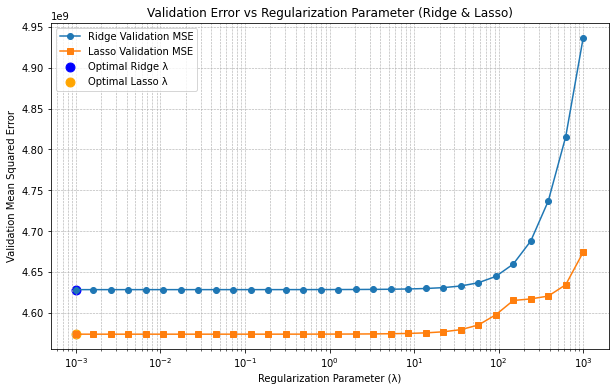


=== Test Set Performance ===
Ridge Regression → MSE: 5,143,672,693.73, MAE: 51,229.40
Lasso Regression → MSE: 5,119,928,534.64, MAE: 50,983.64


In [86]:
# VI. REGULARIZATION TUNING & PLOTTING (Manual Implementation)

print("  REGULARIZATION TUNING (Ridge and Lasso)")

# --- 1. Define Lambda Range ---
lambda_values = np.logspace(-3, 3, 30)  # from 10^-6 to 10^2

ridge_validation_errors = []
lasso_validation_errors = []

# --- 2. Ridge Regression (manual gradient descent version) ---
for lambda_val in lambda_values:
    ridge_weights = ridge_gradient_descent(
        X_train_with_bias_scaled, T_train_col,
        lambda_reg=lambda_val,
        learning_rate=0.01,
        n_iterations=5000
    )
    T_validation_predict_ridge = X_validation_with_bias_scaled @ ridge_weights
    mse_val = calculate_mse(T_validation_col, T_validation_predict_ridge)
    ridge_validation_errors.append(mse_val)

# --- 3. Lasso Regression (using sklearn) ---
for lambda_val in lambda_values:
    lasso = Lasso(alpha=lambda_val, max_iter=50000)
    lasso.fit(X_train_scaled, T_train_col.ravel())  # no bias column
    T_validation_predict_lasso = lasso.predict(X_validation_scaled)
    mse_val = mean_squared_error(T_validation_col, T_validation_predict_lasso)
    lasso_validation_errors.append(mse_val)

# --- 4. Optimal Lambdas ---
optimal_lambda_ridge = lambda_values[np.argmin(ridge_validation_errors)]
optimal_lambda_lasso = lambda_values[np.argmin(lasso_validation_errors)]

print(f"Optimal Ridge λ: {optimal_lambda_ridge:.4e}")
print(f"Optimal Lasso λ: {optimal_lambda_lasso:.4e}")

# --- 5. Plot Validation Error ---
plt.figure(figsize=(10, 6))
plt.semilogx(lambda_values, ridge_validation_errors, label='Ridge Validation MSE', marker='o')
plt.semilogx(lambda_values, lasso_validation_errors, label='Lasso Validation MSE', marker='s')

plt.scatter(optimal_lambda_ridge, np.min(ridge_validation_errors), color='blue', s=80, label='Optimal Ridge λ')
plt.scatter(optimal_lambda_lasso, np.min(lasso_validation_errors), color='orange', s=80, label='Optimal Lasso λ')

plt.xlabel("Regularization Parameter (λ)")
plt.ylabel("Validation Mean Squared Error")
plt.title("Validation Error vs Regularization Parameter (Ridge & Lasso)")
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.6)
plt.show()

# --- 6. Retrain Final Models with Optimal Lambdas ---
ridge_weights_opt = ridge_gradient_descent(
    X_train_with_bias_scaled, T_train_col,
    lambda_reg=optimal_lambda_ridge,
    learning_rate=0.01,
    n_iterations=5000
)

lasso_opt = Lasso(alpha=optimal_lambda_lasso, max_iter=10000)
lasso_opt.fit(X_train_scaled, T_train_col.ravel())

# --- 7. Predict on Test Set ---
T_test_predict_ridge = X_test_with_bias_scaled @ ridge_weights_opt
T_test_predict_lasso = lasso_opt.predict(X_test_scaled)

# --- 8. Compute MSE and MAE ---
ridge_mse = mean_squared_error(T_test_col, T_test_predict_ridge)
ridge_mae = mean_absolute_error(T_test_col, T_test_predict_ridge)

lasso_mse = mean_squared_error(T_test_col, T_test_predict_lasso)
lasso_mae = mean_absolute_error(T_test_col, T_test_predict_lasso)

# --- 9. Report Results ---
print("\n=== Test Set Performance ===")
print(f"Ridge Regression → MSE: {ridge_mse:,.2f}, MAE: {ridge_mae:,.2f}")
print(f"Lasso Regression → MSE: {lasso_mse:,.2f}, MAE: {lasso_mae:,.2f}")



In [89]:

# V-B. GRADIENT DESCENT USING SCIKIT-LEARN

"""
SGDRegressor uses Stochastic Gradient Descent (SGD) by default,
which updates weights after each sample (or mini-batch).
We configure it to behave more like Batch GD for fair comparison.

Key parameters:
- max_iter: maximum number of epochs (passes through dataset)
- learning_rate: 'constant' with eta0 to match our learning rate
- penalty: None for standard linear regression (no regularization)
- tol: tolerance for stopping criterion
"""

# Initialize SGDRegressor
sgd_regressor = SGDRegressor(
    max_iter=2000,           # Match our n_iterations
    learning_rate='constant', # Use constant learning rate
    eta0=0.01,               # Match our learning_rate
    penalty=None,            # No regularization (standard linear regression)
    random_state=42,         # For reproducibility
    tol=1e-6                 # Stopping tolerance
)

# Train on scaled training data (without bias term - sklearn adds it automatically)
sgd_regressor.fit(X_train_scaled, T_train_col.ravel())

# Get coefficients (sklearn handles bias separately)
W_sklearn = np.concatenate([[sgd_regressor.intercept_[0]], sgd_regressor.coef_])

# --- Predict on Validation and Test Sets ---
T_validation_predict_sklearn = sgd_regressor.predict(X_validation_scaled).reshape(-1, 1)
T_test_predict_sklearn = sgd_regressor.predict(X_test_scaled).reshape(-1, 1)

print("\nScikit-Learn SGD predictions completed.")


Scikit-Learn SGD predictions completed.


In [96]:
# 5. COMPARISON AND EVALUATION Using SciKit

def compare_metrics_all(
    T_true,
    T_pred_normal,
    T_pred_gd,
    T_pred_sklearn,
    T_pred_ridge,
    T_pred_lasso,
    model_type
):
    """Calculates and compares MSE and MAE for all models including Ridge & Lasso."""
    
    # --- Normal Equation ---
    mse_normal = mean_squared_error(T_true, T_pred_normal)
    mae_normal = mean_absolute_error(T_true, T_pred_normal)
    
    # --- Manual Gradient Descent ---
    mse_gd = mean_squared_error(T_true, T_pred_gd)
    mae_gd = mean_absolute_error(T_true, T_pred_gd)
    
    # --- Scikit-Learn SGD ---
    mse_sklearn = mean_squared_error(T_true, T_pred_sklearn)
    mae_sklearn = mean_absolute_error(T_true, T_pred_sklearn)
    
    # --- Ridge Regression ---
    mse_ridge = mean_squared_error(T_true, T_pred_ridge)
    mae_ridge = mean_absolute_error(T_true, T_pred_ridge)
    
    # --- Lasso Regression ---
    mse_lasso = mean_squared_error(T_true, T_pred_lasso)
    mae_lasso = mean_absolute_error(T_true, T_pred_lasso)
    
    # --- comparison table ---
    metrics_df = pd.DataFrame({
        'Metric': ['MSE', 'MAE'],
        'Normal Eq.': [f'{mse_normal:,.2f}', f'{mae_normal:,.2f}'],
        'Manual GD': [f'{mse_gd:,.2f}', f'{mae_gd:,.2f}'],
        'Scikit-Learn SGD': [f'{mse_sklearn:,.2f}', f'{mae_sklearn:,.2f}'],
        'Ridge': [f'{mse_ridge:,.2f}', f'{mae_ridge:,.2f}'],
        'Lasso': [f'{mse_lasso:,.2f}', f'{mae_lasso:,.2f}']
    })
    
    print(f"\n--- Model Performance Comparison on the {model_type} ---")
    display(metrics_df)
    return metrics_df




In [101]:
# V-C. COMPREHENSIVE COMPARISON OF ALL METHODS


# --- Compare Metrics on Test Set ---
print("         TEST SET METRICS COMPARISON")
# Compare all models
compare_metrics_all(
    T_test_col,
    T_test_prediction,
    T_test_predict_gd,
    T_test_predict_sklearn,
    T_test_predict_ridge,
    T_test_predict_lasso,
    "Test Set"
)


# -- comments on the results and comparison between the models -- 
print(f"\ncomments on the results and comparison between the models:")
print(f"  - All three methods should produce similar results on scaled data")
print(f"  - Small differences may occur due to:")
print(f"    * Different convergence criteria")
print(f"    * Numerical precision")
print(f"    * Implementation details (batch vs stochastic updates)")

         TEST SET METRICS COMPARISON

--- Model Performance Comparison on the Test Set ---


,Metric,Normal Eq.,Manual GD,Scikit-Learn SGD,Ridge,Lasso
0,MSE,"5,139,417,461.45","5,151,602,316.86","5,233,178,299.54","5,143,672,693.73","5,119,928,534.64"
1,MAE,"51,162.82","51,567.49","52,930.36","51,229.40","50,983.64"



comments on the results and comparison between the models:
  - All three methods should produce similar results on scaled data
  - Small differences may occur due to:
    * Different convergence criteria
    * Numerical precision
    * Implementation details (batch vs stochastic updates)
